<a href="https://colab.research.google.com/github/Kaushik896/Project_XG_BOOST/blob/main/Gradient_Boosting_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intoduction

In this project we are dealing with a data set where we have a Prediction problem.

## Problem Statement:

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# First we install the required modules 
!pip install numpy pandas matplotlib seaborn --quiet
!pip install xgboost graphviz lightgbm scikit-learn  xgboost lightgbm --upgrade
!pip list | grep xgboost
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)    


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Unins

In [3]:
ross_df = pd.read_csv('/content/drive/MyDrive/RossmanDataSet/train.csv', low_memory = False)
ross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
store_df = pd.read_csv('/content/drive/MyDrive/RossmanDataSet/store.csv')
test_df = pd.read_csv('/content/drive/MyDrive/RossmanDataSet/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/RossmanDataSet/sample_submission.csv')

In [5]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


Let's merge the information from `store_df` into `train_df` and test_df

In [6]:
merged_df = ross_df.merge(store_df, how = 'left', on = 'Store')
merged_test_df = test_df.merge(store_df, how = 'left', on = 'Store')

## Preprocessing and Feature Engineering

In [7]:
merged_df.info()

def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Day'] = df.Date.dt.day
  df['Weekofyear'] = df.Date.dt.isocalendar().week

split_date(merged_df)
split_date(merged_test_df)


merged_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Weekofyear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


In [8]:
merged_df[merged_df.Open == 0].Sales.value_counts()
merged_df[merged_df.Open == 0].Sales


291        0
875        0
1406       0
1990       0
2521       0
          ..
1017204    0
1017205    0
1017206    0
1017207    0
1017208    0
Name: Sales, Length: 172817, dtype: int64

Insted of trying to model this relationship, it would be better to hard-core it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.



In [9]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition:

Next, we can use the columns CompetitionOpenSince[month/year] columns from store_df to compute the number of months for which a competitor has been open near the store.



In [10]:
def comp_months(df):
  df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [11]:
comp_months(merged_df)
comp_months(merged_test_df)

In [12]:
## Now viewing the results of the columns we have created:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpen', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].sample(10)


,Date,CompetitionDistance,CompetitionOpen,CompetitionOpenSinceYear,CompetitionOpenSinceMonth
907817,2013-04-09,3460.0,0.0,2013.0,10.0
485932,2014-04-22,12700.0,12.0,2013.0,4.0
774428,2013-08-06,6540.0,68.0,2007.0,12.0
755513,2013-08-23,1310.0,278.0,1990.0,6.0
836549,2013-06-12,4030.0,0.0,2015.0,2.0
950388,2013-03-01,3320.0,0.0,NaN,NaN
72355,2015-05-28,2870.0,0.0,2015.0,7.0
268894,2014-11-27,1360.0,111.0,2005.0,8.0
718470,2013-09-25,2370.0,30.0,2011.0,3.0
582740,2014-01-25,1800.0,86.0,2006.0,11.0


## Additional Promotion

We can also add some additional columns to indicate how long a sotre has been running Promo2 and whether a new round of Promo2 starts in the current month.



In [13]:
def check_promo_month(row):
  month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
               7: 'Jul', 8:'Aug', 9:'Sept', 10: 'Oct', 11:'Nov', 12:'Dec'}
  try:
    months = (row['PromoInterval'] or '').split(',')
    if row['Promo2Open'] and month2str[row['Month']] in months:
      return 1
    else:
      return 0
  except Exception:
    return 0

def promo_cols(df):
  # Months since Promo2 was open
  df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) + (df.Weekofyear - df.Promo2SinceWeek)*7/30.5
  df['Promo2Open'] = df['Promo2Open'].map(lambda x:0 if x < 0 else x).fillna(0) * df['Promo2']
  # Whether a new round of promotions was started in the current month
  df['IsPromo2Month'] = df.apply(check_promo_month, axis = 1) * df['Promo2']

In [14]:
promo_cols(merged_df)
promo_cols(merged_test_df)     

In [ ]:
merged_df

In [ ]:
# Let's view the results of the columns created:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']]
     

Now identifying Input and Target columns


In [17]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'Weekofyear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [19]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()    

In [20]:
test_inputs = merged_test_df[input_cols].copy()

Now we identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [21]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'Weekofyear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']


## Imputing missing numerical Data:


In [ ]:
inputs[numeric_cols].isna().sum(),test_inputs[numeric_cols].isna().sum()

Seems like competition distance is the only missing value, and we can simply fill it with the highest value(to indicate that competition is very far away).

In [25]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [26]:
inputs["CompetitionDistance"].fillna(max_distance*2, inplace = True)
test_inputs["CompetitionDistance"].fillna(max_distance*2, inplace = True)

### Now scaling numeric values

Here the scaling is done to the 0 to 1 range. For this MinMaxScaler is used form sklearn.preprocessing.

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### One-hot encoding

In [31]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
x = inputs[numeric_cols + encoded_cols]
x_test = test_inputs[numeric_cols + encoded_cols]

## Gradient Boosting Machine

Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations.

To train a GBM, we can use the XGBRegressor class from the XGBoost library

In [34]:
from xgboost import XGBRegressor

In [35]:
model = XGBRegressor(random_state = 42, n_jobs = -1, n_estimators = 30, max_depth = 4)

In [ ]:
%%time
model.fit(x, targets)

In [37]:
preds = model.predict(x)

In [38]:
from sklearn.metrics import mean_squared_error
def rmse(a, b):
  return mean_squared_error(a, b, squared = False)

In [39]:
rmse(preds, targets)

2238.906033631746

In [40]:
merged_df.Sales.min(), merged_df.Sales.max()

(0, 41551)

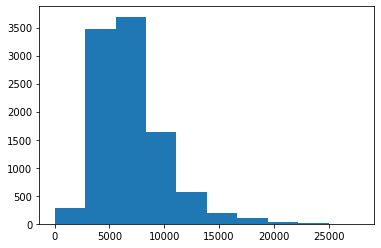

In [41]:
import matplotlib.pyplot as plt
plt.hist(merged_df.Sales.sample(10000))
plt.show()

## Visualizations

In [43]:
## individual trees can be visualized using plot_tree
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

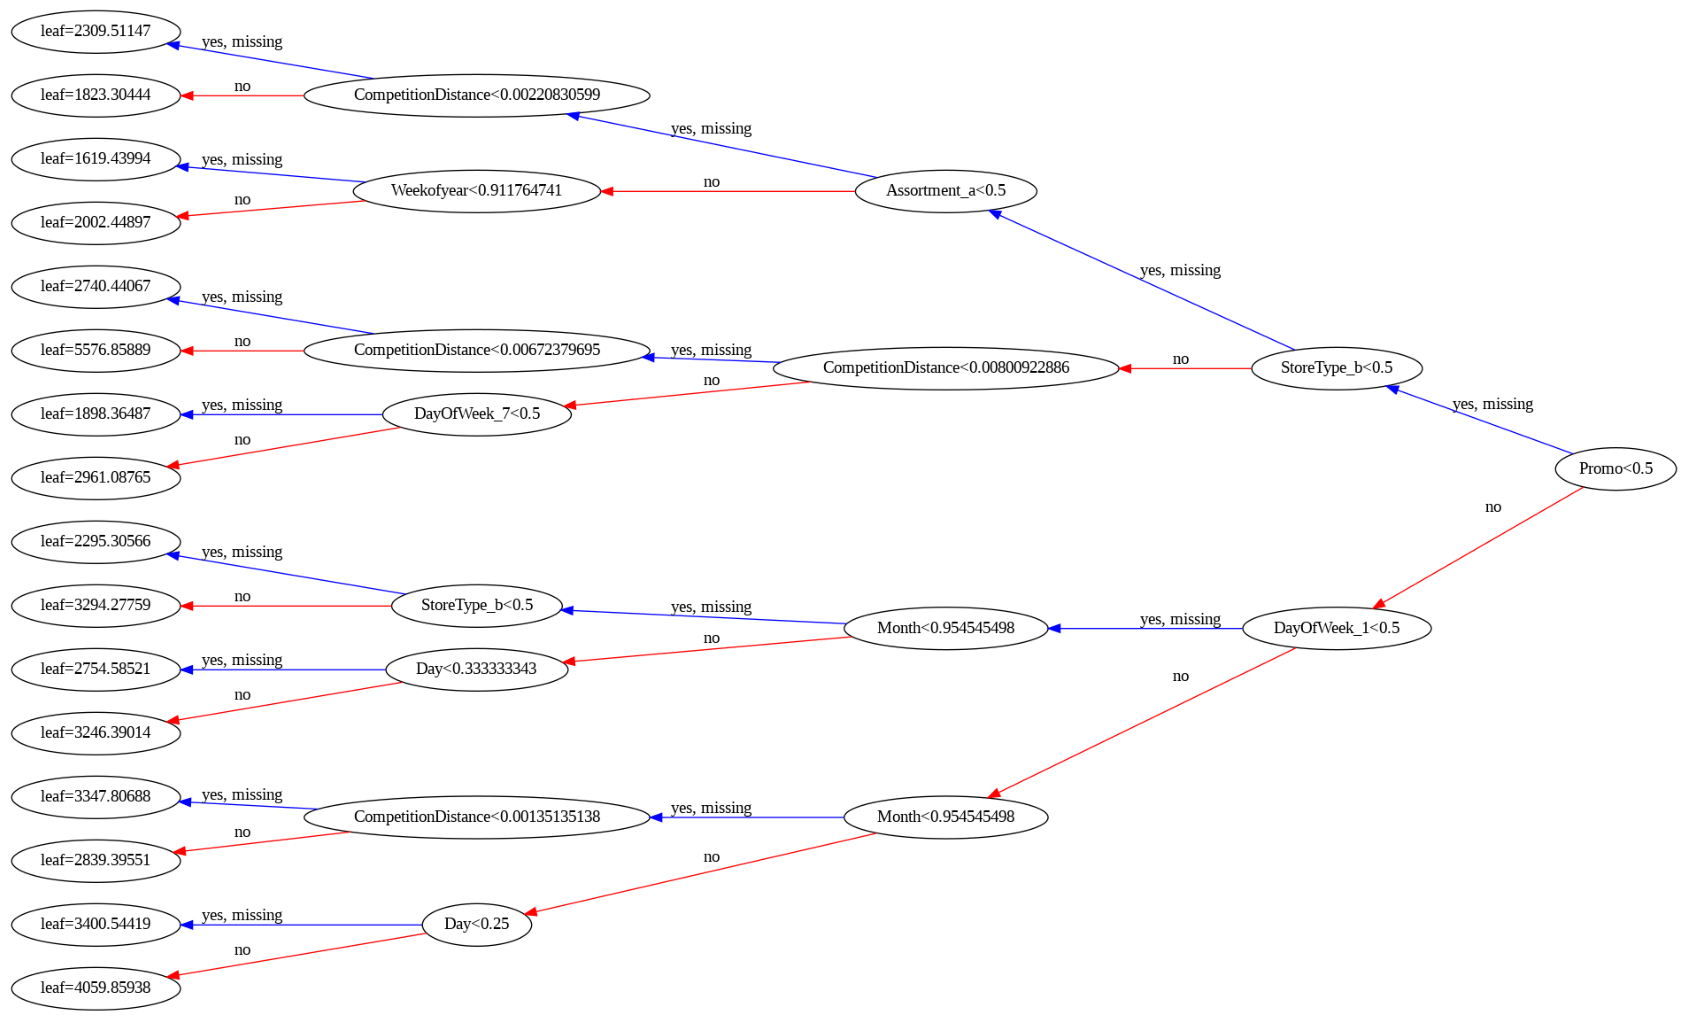

In [44]:
rcParams['figure.figsize'] = 30, 30
plot_tree(model, rankdir = 'RL', num_trees=0)

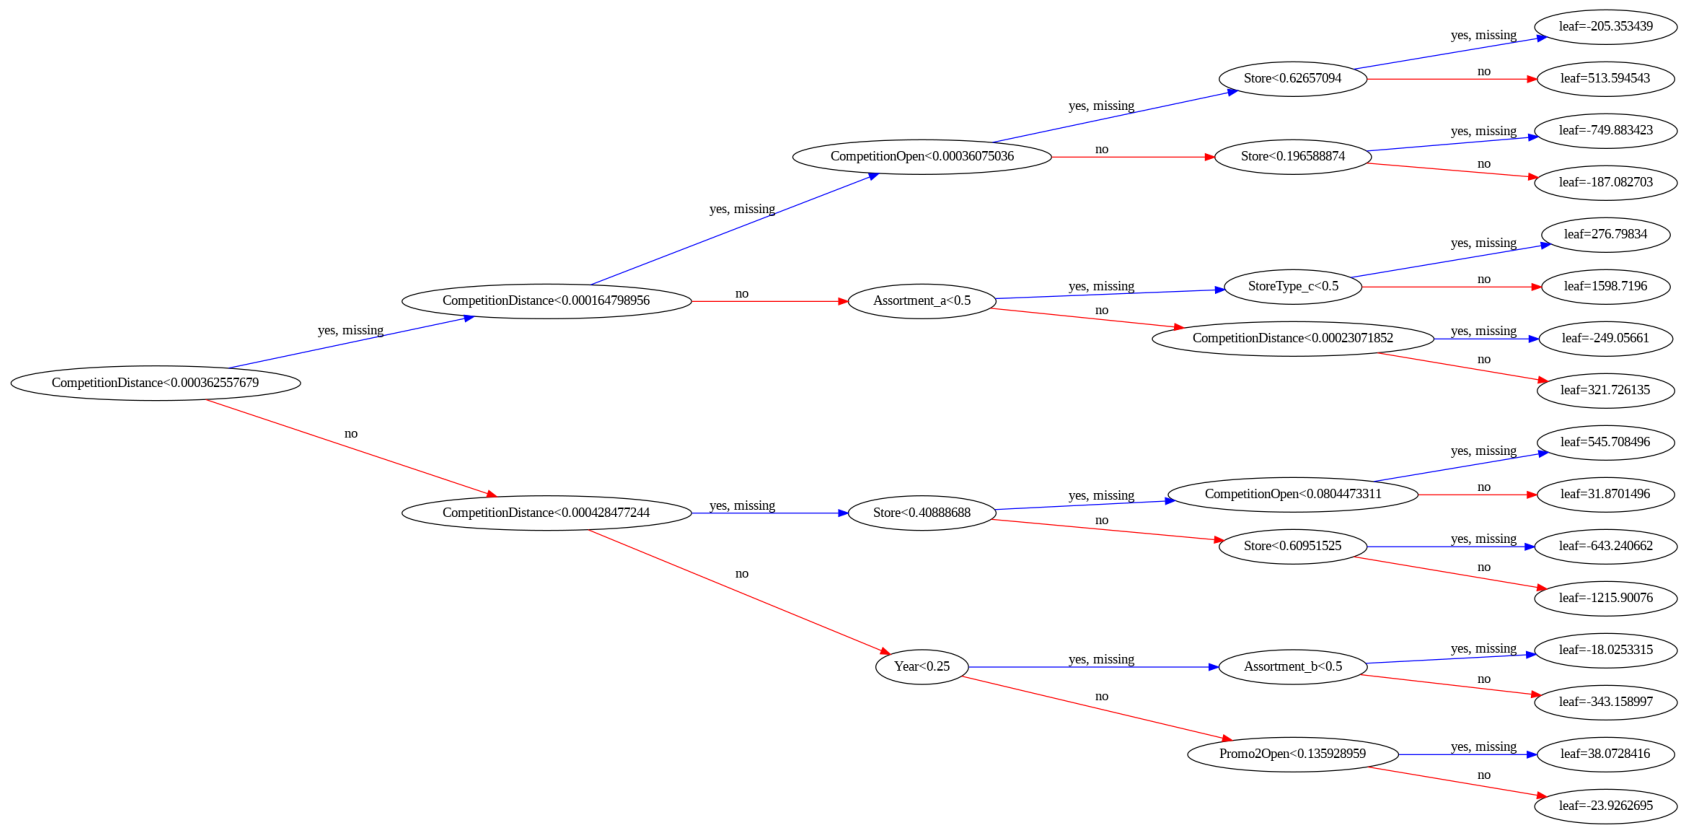

In [45]:
plot_tree(model, rankdir = 'LR', num_trees=25)


The trees only compute residuals, and not actual target value.

In [46]:
trees = model.get_booster().get_dump()
len(trees)

30

## Feature Importance

In [47]:
importance_df = pd.DataFrame({
    'feature': x.columns, 
    'importance':model.feature_importances_
}).sort_values('importance', ascending = False)

In [48]:
importance_df.head()

,feature,importance
1,Promo,0.269809
24,StoreType_b,0.084813
12,DayOfWeek_1,0.083178
5,Promo2,0.073182
0,Store,0.039969


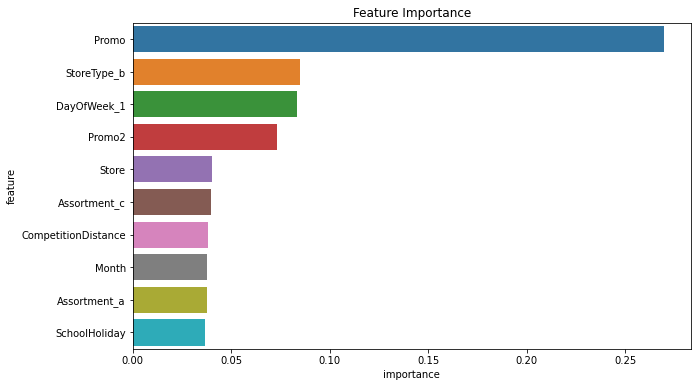

In [49]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

This shows that creating columns like months has improved our model.

## K Fold Cross Validation

k-Fold Cross-Validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into.

In [50]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5, shuffle = True)

Here we define a helper function train_and_evaluate which trains a model the given parameters and returns the trained model, training error and validation error.

In [51]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [52]:
models = []

for train_idxs, val_idxs in kfold.split(x):
    X_train, train_targets = x.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = x.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))
     

Train RMSE: 2345.521912090601, Validation RMSE: 2352.94170433868
Train RMSE: 2379.0275511207487, Validation RMSE: 2380.79672442074
Train RMSE: 2370.5720789114757, Validation RMSE: 2367.163071738599
Train RMSE: 2361.9186867031126, Validation RMSE: 2354.430466806015
Train RMSE: 2362.475511497833, Validation RMSE: 2372.4436806472386


In [53]:
# defining a function to average predictions from the 5 different models.

import numpy as np

def predict_avg(models, inputs):
  return np.mean([model.predict(inputs) for model in models], axis = 0)
     

In [54]:
preds = predict_avg(models, x)

In [55]:
preds

array([8057.3135, 7550.425 , 8335.302 , ..., 8068.9766, 7418.914 ,
       9712.303 ], dtype=float32)

In [56]:
preds = predict_avg(models, x_test)
preds

array([ 6957.103 ,  7325.236 ,  8356.464 , ...,  6766.9326, 20021.371 ,
        6911.8213], dtype=float32)

## Hyperparameter Tuning and Regularization

In [57]:
# A helper function to test hyperparameter with k_fold cross validation

def test_params_kfold(n_splits, **params):

  train_rmses, val_rmses, models = [], [], []
  kfold = KFold(n_splits)

  for train_idxs, val_idxs in kfold.split(x):
    x_train, train_targets = x.iloc[train_idxs], targets.iloc[train_targets]
    x_val, val_targets = x.iloc[val_idxs], targets.iloc[val_targets]

    model, train_tmse, val_rmse = train_and_evaluate(x_train, train_targets, x_val, val_targets, **params)
    models.append(model)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
  print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
  return models

In [58]:
from sklearn.model_selection import train_test_split
x_train, x_val, train_targets, val_targets = train_test_split(x, targets, test_size=0.1)
def test_params(**params):
  model = XGBRegressor(n_jobs = -1, random_state = 42, **params)
  model.fit(x_train, train_targets)
  train_rmse = rmse(model.predict(x_train), train_targets)
  val_rmse = rmse(model.predict(x_val), val_targets)
  print('Train Rmse: {}, Validation Rmse: {}'.format(train_rmse, val_rmse))


#### n_estimators

The number of trees to be created. More trees = greater capacity of the model.

In [60]:
test_params(n_estimators = 10), test_params(n_estimators = 100)

Train Rmse: 2341.1481389648484, Validation Rmse: 2325.6392548461426


KeyboardInterrupt: ignored

#### max_depth

As you increase the max depth of each tree, the capacity of each tree increases and it can capture more information about the training set.

In [61]:
test_params(max_depth = 4, n_estimators = 10), test_params(max_depth = 20, n_estimators = 10)

Train Rmse: 2521.574685872745, Validation Rmse: 2504.2244486265936
Train Rmse: 845.9752919612428, Validation Rmse: 1170.6578224806321


(None, None)

#### Learning Rate

The scaling factor to be applied to the prediction of each tree. A very high learning rate(close to 1) will lead to overfitting and a low learning rate(close to 0) will lead to underfitting.

In [62]:
test_params(n_estimators = 50, learning_rate = 0.01), test_params(n_estimators = 50, learning_rate = 0.4), test_params(n_estimators = 50, learning_rate = 0.99)

Train Rmse: 5045.543012661001, Validation Rmse: 5025.734383369747
Train Rmse: 1435.1891188468032, Validation Rmse: 1430.9829568047312
Train Rmse: 1151.6078700789494, Validation Rmse: 1165.3648939069526


(None, None, None)

#### booster

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration, This can be configured using booster.

In [63]:
test_params(booster = 'gblinear')

Train Rmse: 2728.852246620518, Validation Rmse: 2713.169322125292


Let's train a final model on the entire training set with custom hyperparameters.

In [64]:
model = XGBRegressor(n_jobs = -1, random_state = 42, n_estimators = 100, 
                     learning_rate = 0.2, max_depth = 10, subsample = 0.9,
                     colsample_bytree = 0.7)

In [65]:
%%time 
model.fit(x, targets)

CPU times: user 6min 19s, sys: 705 ms, total: 6min 19s
Wall time: 3min 44s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [66]:
test_preds = model.predict(x_test)
test_preds

array([ 3993.1938,  7254.117 ,  9163.771 , ...,  6773.2285, 21662.088 ,
        6519.111 ], dtype=float32)

In [67]:
# adding the predictions into the submission_df

submission_df['Sales'] = test_preds
submission_df = submission_df[['Id', 'Sales']]
test_df.Open.isna().sum()
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)
submission_df.sample(50)
submission_df.to_csv('submission.csv', index=None)